In [1]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt
from IPython.display import Image, display
import matplotlib.image as mpimg

import copy
import json
import numpy as np
import os
import yaml
import re
import shlex
import torch

from tqdm import tqdm

torch.cuda.empty_cache()
# !nvidia-smi

In [2]:
def parse_annotations(annotations):
    types = {}
    qid_to_type = {}
    type_to_qids = {}

    for a in annotations:
        qtype = a['question_type']
        qid = a['question_id']
        if qtype not in types:
            types[qtype] = []
        for answer in a['answers']:
            types[qtype].append(answer['answer'])
        qid_to_type[qid] = qtype
        if qtype not in type_to_qids:
            type_to_qids[qtype] = [qid]
        else:
            type_to_qids[qtype].append(qid)
        
    return types, qid_to_type, type_to_qids

In [3]:
with open('data_prep/vqa_v1.0_cp/vqacp_v1_trainsplit_annotations.json', 'r') as f:
    trainsplit_annotations = json.load(f)
    trainsplit_types, trainsplit_qid_to_type, trainsplit_type_to_qids = parse_annotations(trainsplit_annotations)

In [4]:
with open('data_prep/vqa_v1.0_cp/vqacp_v1_test_annotations.json', 'r') as f:
    test_annotations = json.load(f)
    test_types, test_qid_to_type, test_type_to_qids = parse_annotations(test_annotations)

In [6]:
def viz_prior(qtype, types):
    c = Counter(types[qtype])
    top_k = dict(c.most_common(10))
    other_count = sum(c.values()) - sum(top_k.values())
    top_k['other'] = other_count
    print(top_k)
    plt.pie([float(v) for v in top_k.values()], labels=top_k.keys(),
           autopct=None)
    plt.show()
    return top_k

# VQA model

In [5]:
import numpy as np
import torch

from config.config_utils import finalize_config, dump_config
from train_model.Engineer import one_stage_run_model, masked_unk_softmax
from train_model.dataset_utils import prepare_train_data_set, \
    prepare_eval_data_set, prepare_test_data_set
from train_model.helper import build_model, run_model, print_result
from torch.utils.data import DataLoader

In [6]:
def filter_dataset(dataset, qtype, type_to_qids):
    valid_qids = type_to_qids[qtype]
    imdb_idxs = [0]
    for i, ex in enumerate(dataset.imdb):
        if i > 0:
            qid = ex['question_id']
            if qid in valid_qids:
                imdb_idxs.append(i)
    new_dataset = copy.deepcopy(dataset)
    new_dataset.imdb = dataset.imdb[imdb_idxs]
    return new_dataset

In [7]:
def display_result(info, softmax_res):
    questions = info['question_str']
    images = info['image_name']
    predicted_answers = np.argmax(softmax_res, axis=1)
    answers = []
    for i in range(predicted_answers.shape[0]):
        pred_ans = ans_dic.idx2word(predicted_answers[i])
        print(i, questions[i], images[i], pred_ans)
        answers.append(pred_ans)
    return answers

In [8]:
regularized_model_save = 'results/vqa_v1_adv_cp/training_parameters.lambda_grl.-0.1_lambda_q.0.1_888_kangaroo2/best_model.pth'
baseline_model_save = 'results/vqa_v1_adv_cp/training_parameters.lambda_grl.0_lambda_q.0.001_888_giraffe/best_model.pth'

In [9]:
from config.config import cfg
def process_config(config_file, config_string):
    finalize_config(cfg, config_file, config_string)

process_config('config/keep/vqa_v1_adv_cp.yaml', None)

In [10]:
dataset_test = prepare_test_data_set(**cfg['data'], **cfg['model'])
dataset_test.verbose = True
ans_dic = dataset_test.answer_dict
print("=> Loaded testset: {} examples".format(len(dataset_test)))

=> Loading CP dataset
imdb does not contain ground-truth layout
Loading model and config ...
=> Loaded testset: 125314 examples


In [141]:
qtype = 'what animal is'
dataset_filtered = filter_dataset(dataset_test, qtype, test_type_to_qids)
len(dataset_filtered)

351

In [142]:
data_reader_test = DataLoader(dataset_filtered,
                              shuffle=False,
                              batch_size=min(len(dataset_filtered), 500),
                              num_workers=cfg.data.num_workers)

In [143]:
regularized_model, _ = build_model(cfg, dataset_test)
regularized_model.load_state_dict(torch.load(regularized_model_save)['state_dict'])
regularized_model.eval()
print('done')

done


In [144]:
baseline_model, _ = build_model(cfg, dataset_test)
baseline_model.load_state_dict(torch.load(baseline_model_save)['state_dict'])
baseline_model.eval()
print('done')

done


In [145]:
def get_scores(model, data_reader, ans_dic):
    for i, batch in enumerate(data_reader_test):
        logit_res = one_stage_run_model(batch, model, eval_mode=True)
        softmax_res_tensor = masked_unk_softmax(logit_res, dim=1, mask_idx=ans_dic.UNK_idx)
        info = batch['verbose_info']
        break
    return softmax_res_tensor.data.cpu().numpy().astype(np.float16), info

In [146]:
# def get_scores(model, data_reader, ans_dic):
#     softmax_res_list = []
#     info_list = []
#     for i, batch in enumerate(data_reader_test):
#         logit_res = one_stage_run_model(batch, model, eval_mode=True)
#         softmax_res_tensor = masked_unk_softmax(logit_res, dim=1, mask_idx=ans_dic.UNK_idx)
#         softmax_res_list.append(softmax_res_tensor.data.cpu().numpy().astype(np.float16))
#         info = batch['verbose_info']
#         info_list.append(info)
        
#     softmax_out = np.vstack(softmax_res_list)
#     info_out = {k: [] for k in info_list[0].keys()}
#     for info_d in info_list:
#         for k in info_out.keys():
#             if type(info_d[k]) == list:
#                 info_out[k] = info_out[k] + info_d[k]
    
#     return softmax_out, info_out

In [147]:
baseline_scores, baseline_info = get_scores(baseline_model, data_reader_test, dataset_test.answer_dict)
regularized_scores, regularized_info = get_scores(regularized_model, data_reader_test, dataset_test.answer_dict)

In [148]:
baseline_info.keys()

dict_keys(['image_name', 'image_id', 'question_id', 'feature_path', 'question_str', 'question_tokens', 'all_answers', 'valid_answers'])

In [149]:
baseline_answers = display_result(baseline_info, baseline_scores)

0 What animal is in the image? COCO_train2014_000000097373 horse
1 What animal is this? COCO_train2014_000000142274 dog
2 What animal is in front of the camera? COCO_train2014_000000533424 horse
3 What animal is this? COCO_train2014_000000138350 horse
4 What animal is this? COCO_train2014_000000422608 horse
5 What animal is pictured? COCO_train2014_000000248229 horse
6 What animal is in this picture? COCO_train2014_000000477015 horse
7 What animal is this? COCO_train2014_000000328163 horse
8 What animal is used? COCO_train2014_000000207941 elephant
9 What animal is carrying the other? COCO_train2014_000000416054 elephant
10 What animal is this? COCO_train2014_000000571311 horse
11 What animal is here? COCO_train2014_000000363576 horse
12 What animal is pulling the cart? COCO_train2014_000000235358 horse
13 What animal is this? COCO_train2014_000000440311 horse
14 What animal is in the scene? COCO_train2014_000000301985 horse
15 What animal is in this photo? COCO_train2014_000000303227 

In [150]:
regularized_answers = display_result(regularized_info, regularized_scores)

0 What animal is in the image? COCO_train2014_000000097373 horse
1 What animal is this? COCO_train2014_000000142274 dog
2 What animal is in front of the camera? COCO_train2014_000000533424 horse
3 What animal is this? COCO_train2014_000000138350 horse
4 What animal is this? COCO_train2014_000000422608 horse
5 What animal is pictured? COCO_train2014_000000248229 beach
6 What animal is in this picture? COCO_train2014_000000477015 elephant
7 What animal is this? COCO_train2014_000000328163 polo
8 What animal is used? COCO_train2014_000000207941 horse
9 What animal is carrying the other? COCO_train2014_000000416054 cow
10 What animal is this? COCO_train2014_000000571311 horse
11 What animal is here? COCO_train2014_000000363576 horse
12 What animal is pulling the cart? COCO_train2014_000000235358 horse
13 What animal is this? COCO_train2014_000000440311 horse
14 What animal is in the scene? COCO_train2014_000000301985 horse
15 What animal is in this photo? COCO_train2014_000000303227 horse


144 What animal is this? COCO_train2014_000000564735 broccoli
145 What animal is at the far end of the table? COCO_train2014_000000006247 dog
146 What animal is on the cereal box? COCO_train2014_000000381957 kitchen
147 What animal is represented by the kite on the left? COCO_train2014_000000417487 kites
148 What animal is on the sign? COCO_train2014_000000313286 elephant
149 What animal is on the bottle? COCO_train2014_000000376697 beer
150 What animal is riding the train? COCO_train2014_000000229262 train
151 What animal is shown? COCO_train2014_000000257517 vegetables
152 What animal is on the end of the toothbrush? COCO_train2014_000000162780 toothbrush
153 What animal is seen in the air? COCO_train2014_000000002963 bear
154 What animal is printed on the shirt? COCO_train2014_000000282667 white
155 What animal is shown on the box on the left? COCO_train2014_000000539449 bananas
156 What animal is primarily the same color scheme as the train? COCO_train2014_000000556647 orange
157 W

In [22]:
def viz_model_output(softmax_res_tensor, ans_dic):
    values, idxs = softmax_res_tensor.topk(10)
    answers = [ans_dic.idx2word(idx) for idx in idxs]
    scores = [v.item() for v in values]
    
    answers.append('other')
    scores.append(1 - sum(scores))
        
    plt.pie(scores, labels=answers, autopct=None)
    plt.show()

In [23]:
def compare_scores(baseline_scores, baseline_info, regularized_scores, regularized_info, ans_dic, q_idx):
    print('Q:', baseline_info['question_str'][q_idx])
    print('A:', baseline_info['valid_answers'][0][q_idx])
    print('baseline')
    viz_model_output(baseline_scores[q_idx], ans_dic)
    print('regularized')
    viz_model_output(regularized_scores[q_idx], ans_dic)

In [23]:
compare_scores(baseline_scores, baseline_info, regularized_scores, regularized_info, ans_dic, 181)

Q: What sport is being played?
A: rugby
baseline


AttributeError: 'numpy.ndarray' object has no attribute 'topk'

In [ ]:
compare_scores(baseline_scores, baseline_info, regularized_scores, regularized_info, ans_dic, 218)

In [ ]:
compare_scores(baseline_scores, baseline_info, regularized_scores, regularized_info, ans_dic, 223)

In [ ]:
compare_scores(baseline_scores, baseline_info, regularized_scores, regularized_info, ans_dic, 227)

In [ ]:
# Show the image
# Make pie charts more pretty
    # Fix double-blue

In [30]:
def sort_model_scores(model_scores, q_idx):
    a_idxs = np.argsort(-model_scores[q_idx])
    answers = [ans_dic.idx2word(idx) for idx in a_idxs]
    scores = model_scores[q_idx][a_idxs]
    return list(zip(answers, scores))

sort_model_scores(baseline_scores, 6)

[('no', 1.0),
 ('yes', 4e-07),
 ('<unk>', 0.0),
 ('pie', 0.0),
 ('pier', 0.0),
 ('pig', 0.0),
 ('pigeon', 0.0),
 ('pigeons', 0.0),
 ('pigtails', 0.0),
 ('pillow', 0.0),
 ('pillows', 0.0),
 ('pilot', 0.0),
 ('pine', 0.0),
 ('pineapple', 0.0),
 ('ping pong', 0.0),
 ('pictures', 0.0),
 ('picture', 0.0),
 ('picnic table', 0.0),
 ('picnic', 0.0),
 ('pickles', 0.0),
 ('pickle', 0.0),
 ('piano', 0.0),
 ('photoshop', 0.0),
 ('photography', 0.0),
 ('photographer', 0.0),
 ('photo', 0.0),
 ('phones', 0.0),
 ('phone', 0.0),
 ('phillies', 0.0),
 ('petting', 0.0),
 ('person', 0.0),
 ('pepsi', 0.0),
 ('pink', 0.0),
 ('pink and blue', 0.0),
 ('pink and white', 0.0),
 ('pink and yellow', 0.0),
 ('plow', 0.0),
 ('playing wii', 0.0),
 ('playing tennis', 0.0),
 ('playing soccer', 0.0),
 ('playing game', 0.0),
 ('playing frisbee', 0.0),
 ('playing baseball', 0.0),
 ('playing', 0.0),
 ('play tennis', 0.0),
 ('play', 0.0),
 ('platform', 0.0),
 ('plates', 0.0),
 ('plate', 0.0),
 ('plastic', 0.0),
 ('peppers',

In [31]:
def get_qtype_prior(qtype, types):
    c = Counter(types[qtype])
    tot = sum(c.values())
    c = c.most_common(len(c))
    c = [(label, v / tot) for label, v in c]
    return c

trainsplit_prior = get_qtype_prior('what sport is', trainsplit_types)
test_prior = get_qtype_prior('what sport is', test_types)

In [217]:
def autolabel(ax, rects, labels, values):
    for i in range(len(rects)):
        rect = rects[i]
        if values[i] > 0.02:
            ax.text(rect.get_x() + rect.get_width() / 2.,
                    rect.get_y() + rect.get_height() / 2.,
                    labels[i],
                    ha = 'center',
                    va = 'center',
                    color='white',
                    fontweight=('bold' if values[i] >= 0.1 else None),
                    fontsize=(8 if values[i] >= 0.1 else 6))

def plot_comparison(dist1, dist2, dist3, dist4):
    
    dist_size = max(len(dist1), len(dist2), len(dist3), len(dist4))
    
    if len(dist1) < dist_size:
        dist1 += [('', 0.)] * (dist_size - len(dist1))
    if len(dist2) < dist_size:
        dist2 += [('', 0.)] * (dist_size - len(dist2))
        
    fig = plt.figure(facecolor="white", figsize=(14, 6), dpi=300)
    ax = fig.add_subplot(1, 2, 2)
    bar_width = 0.5
    bar_l = np.arange(0, 4)
    tick_pos = [i for i in bar_l]
    
    colordict = {}

    last = np.array([0., 0., 0., 0.])
    curr_color = 0
    
    dists = [dist1, dist2, dist3, dist4]
    
    labels_array = np.array([[x[0] for x in d] for d in dists]).T
    values_array = np.array([[x[1] for x in d] for d in dists]).T
            
    for i in range(dist_size):
#     for i in range(100):
        
        if i % 100 == 0:
            print(i)
        
        labels = labels_array[i]
        values = values_array[i]
        
        colors = []
        for label in labels:
            if label in colordict:
                n = colordict[label]
            else:
                n = curr_color
                colordict[label] = curr_color
                curr_color = (curr_color + 1) % 10
            colors.append('C' + str(n)) 
        
        rects = ax.bar(bar_l, values, bottom=last, color=colors)

        autolabel(ax, rects, labels, values)

        last += values
        
    plt.xticks(tick_pos, ["Train prior", "Test prior", "Baseline", "Regularized"], fontsize=12)
    plt.yticks([])

    return fig

# Make the magic happen

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


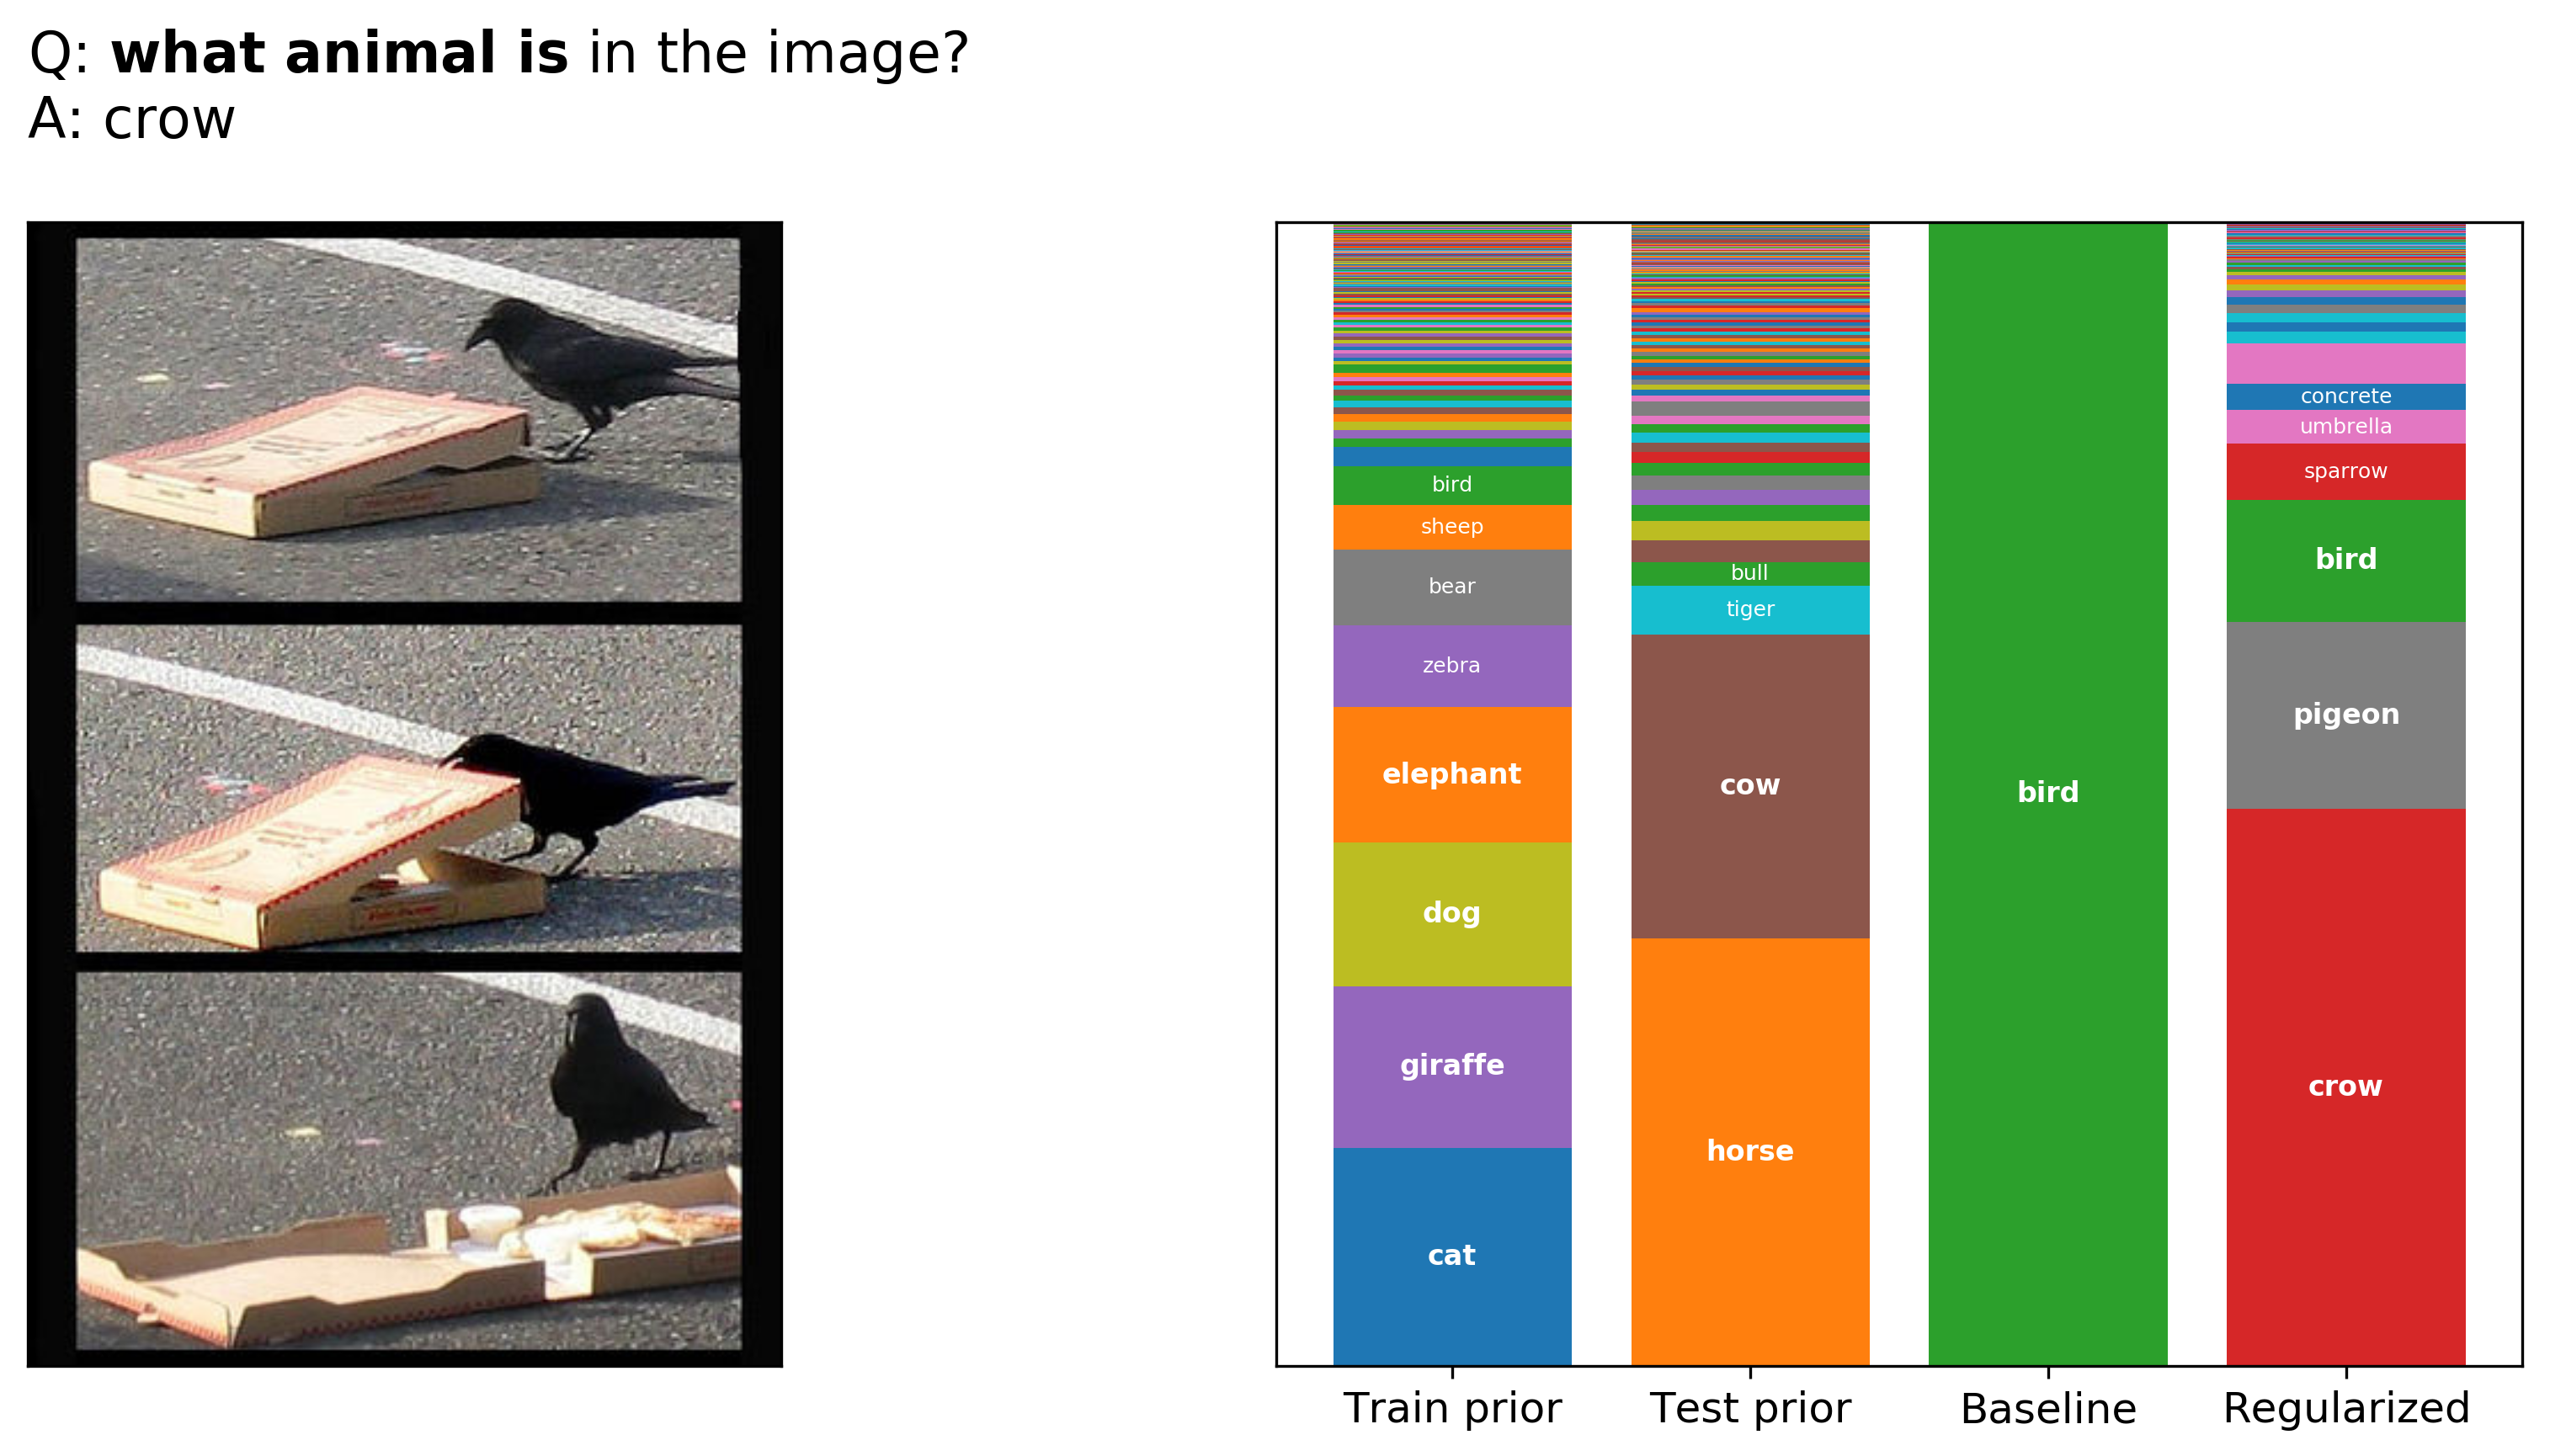

In [218]:
QTYPE = 'what animal is'
QNUM = 331

trainsplit_prior = get_qtype_prior(QTYPE, trainsplit_types)
test_prior = get_qtype_prior(QTYPE, test_types)

baseline_dist = sort_model_scores(baseline_scores, QNUM)
regularized_dist = sort_model_scores(regularized_scores, QNUM)

image_name = baseline_info['image_name'][QNUM]
if 'train' in image_name:
    image_path = 'coco/train2014'
elif 'val' in image_name:
    image_path = 'coco/val2014'
else:
    raise ValueError
    
question = baseline_info['question_str'][QNUM]
answer = baseline_info['valid_answers'][0][QNUM]

qquoted = QTYPE.replace(' ', '\ ')
pattern = re.compile(QTYPE, re.IGNORECASE)
qrest = pattern.sub('', question)
txt = 'Q: ' + r"$\bf{" + qquoted + "}$" + qrest + '\nA: ' + answer + '\n'

fig = plot_comparison(trainsplit_prior, test_prior, baseline_dist, regularized_dist)

fig.add_subplot(121)
ax = plt.gca()

plt.title(txt, FontSize=16, horizontalalignment='left', x=0.0)

ax.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

img = mpimg.imread(os.path.join(image_path, image_name + '.jpg'))
imgplot = ax.imshow(img, interpolation='bilinear')

In [68]:
A = np.array(baseline_info['valid_answers'][0])
ii = np.where(A == 'yes')[0]
ii.shape

(0,)

In [51]:
np.where(np.array(baseline_answers)[ii] == 'yes')[0].shape

(2,)

In [53]:
np.where(np.array(regularized_answers)[ii] == 'yes')[0].shape

(358,)

In [99]:
baseline_info['valid_answers']

[('lady',
  'summer',
  'beef',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'no',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'no',
  'yes',
  'yes',
  'yes',
  'no',
  'yes',
  'yes',
  'yes',
  'yes',
  'no',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'no',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'no',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'no',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  'yes',
  '